# Imports

In [ ]:
from typing import List
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

#ROCKET components

## 1D Convolution

This method is obviously not as optimized as the paper's code (no Numba compilation is performed here). For further tuning, one may implement it in Cython (or even in C) or compile it using Numba.

In [ ]:
def conv_1D_kernel(input_sequence: int, weights: List[float], stride: int, dilation: int, padding: int) -> List[float]:
    sequences_count: int = input_sequence.shape[0]
    input_seq_len: int = input_sequence.shape[1]
    kernel_len: int = len(weights)
    output_len: int = int((input_seq_len + 2 * padding - dilation * (kernel_len - 1) - 1) // stride) + 1
    last_sequence_index: int = int((input_seq_len + padding - dilation * (kernel_len - 1) - 1) // stride) + 1
    indices_shift: int = output_len - last_sequence_index
    output_seq: List[float] = np.zeros((sequences_count, output_len), dtype=np.float64)

    for i in range(-indices_shift, last_sequence_index):

        index = i

        for specific_weight in weights:

            # If the end of the input sequence was reached, the computation is complete.
            if index >= input_seq_len:
                break

            # If there is a padding, the computation should first skip the first zero terms.
            elif index >= 0:
                output_seq[:, i + indices_shift] += specific_weight * input_sequence[:, index]
            index += dilation

    return output_seq

## ROCKET Method

In [ ]:
class ROCKET():
    def __init__(self, kernels_num: int, input_length: int):
        self._kernels_num: int = kernels_num  # K - number of conv kernels
        self._input_length: int = input_length

        self._kernel_lengths: List[int] = list()
        self._biases: List[float] = list()
        self._dilations: List[int] = list()
        self._use_paddings: List[bool] = list()
        self._weights: List[float] = list()

    def fit(self, seed: int = 1995) -> None:
        """
        Generating the random parameters of all the convolution kernels
        (not actual fitting to some given data...)
        """

        rng = np.random.default_rng(seed)
        self._kernel_lengths = rng.choice([7, 9, 11], self._kernels_num)
        self._biases = rng.uniform(-1, 1, self._kernels_num)
        self._use_paddings = rng.integers(2, size=self._kernels_num) > 0
        self._weights = rng.normal(size=int(np.sum(self._kernel_lengths)))
        dilations_exponents = np.log2((self._input_length - 1) / (self._kernel_lengths - 1))
        self._dilations = np.power(2, rng.uniform(0, dilations_exponents)).astype(np.int32)


    def apply(self, input_data):
        """
        Generates the features-map for each sample in the input data.

        Args:
            input_data - an array of float64 with dimensions [N, input_len]

        Returns:
            An array of float64 with dimensions [N, 2*K]
        """
        first_weight_index: int = 0
        last_weight_index: int = 0
        stride: int = 1  # Const
        features_map = np.empty((input_data.shape[0], 2*self._kernels_num))

        for kernel_ind, (kernel_length, bias, use_padding, dilation) in enumerate(zip(
            self._kernel_lengths, self._biases, self._use_paddings, self._dilations)):

            padding_len = 0 
            if use_padding:
                padding_len = int((kernel_length - 1) * dilation / 2)
            last_weight_index += kernel_length
            kernel_weights = self._weights[first_weight_index:last_weight_index]
            kernel_weights -= kernel_weights.mean()
                
            # Performing the convolution and extracting the max and PPV features.
            conv_output = conv_1D_kernel(input_data, kernel_weights, stride, dilation, padding_len)
            features_map[:, 2*kernel_ind] = conv_output.max(axis=1) + bias
            features_map[:, 2*kernel_ind + 1] = \
                np.count_nonzero(conv_output + bias > 0) / len(conv_output)
            
            first_weight_index = last_weight_index

        return features_map

## Logistic Regression + ROCKET

In [ ]:
class RocketLogisticRegression():
    def __init__(self, kernels_num: int, input_length: int, max_iter: int = 100,
                 seed: int = 1995, regularization: str = 'none'):
        self._rocket = ROCKET(kernels_num, input_length)
        self._rocket.fit(seed)
        self._model = LogisticRegression(penalty=regularization, 
                                         max_iter=max_iter)
        
    def fit(self, X, y):
        # Scaling the input sequences to have 0 mean and 1 std,
        # and then performing the features-transform.
        transformed_X = self._rocket.apply(scale(X, axis=1))
        self._model.fit(transformed_X, y)
        
    def predict(self, X):      
        # Scaling the input sequences to have 0 mean and 1 std,
        # and then performing the features-transform.
        transformed_X = self._rocket.apply(scale(X, axis=1))
        return self._model.predict(transformed_X)
    
    def score(self, X, y):      
        # Scaling the input sequences to have 0 mean and 1 std,
        # and then performing the features-transform.
        transformed_X = self._rocket.apply(scale(X, axis=1))
        return self._model.score(transformed_X, y)

# Experiment on Real Data

The used dataset is taken from [here](http://timeseriesclassification.com/description.php?Dataset=ECG5000). This is a dataset of ECG signals of length 140, which are classified into 5 different classes.
The best accuracy (according to the link) on this dataset was achieved by COTE, which is **94.61%**.

Train set size: **500**, Test set size: **4500** (yes, it is **9** times bigger than the train set)

In [ ]:
classes_num: int = 5
train_set = pd.read_csv('ECG5000_TRAIN.txt', header=None, sep='  ')
train_y = train_set[0].to_numpy()
train_X = train_set.drop(train_set.columns[[0]], axis=1).to_numpy()

test_set = pd.read_csv('ECG5000_TEST.txt', header=None, sep='  ')
test_y = test_set[0].to_numpy()
test_X = test_set.drop(test_set.columns[[0]], axis=1).to_numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


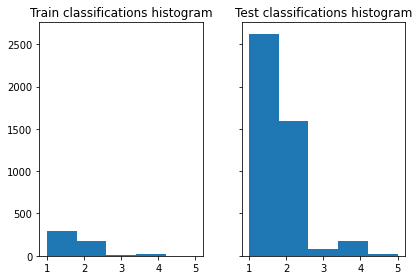

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(train_y, bins=classes_num)
axs[0].set_title('Train classifications histogram')
axs[1].hist(test_y, bins=classes_num)
axs[1].set_title('Test classifications histogram')
plt.show()

Both the train set and the test set consist of mostly sequences of classes **1** and **2**. 
This makes this dataset quiet skewed...

In [ ]:
#@title **Applying ROCKET+LogisticRegression**
kernels_num = 1000 #@param {type:"integer"}
max_iterations = 100 #@param {type:"integer"}
regularizer = "none" #@param ["none", "l2"]
seed = 1995 #@param {type:"integer"}
model = RocketLogisticRegression(kernels_num, train_X.shape[1], 
                                 max_iter=max_iterations, seed=seed,
                                 regularization=regularizer)
model.fit(train_X, train_y)
train_pred = model.predict(train_X)
print(f'Train accuracy: {model.score(train_X, train_pred)}')
test_pred = model.predict(test_X)
print(f'Test accuracy: {model.score(test_X, test_y)}')
print(f'Confusion matrix:\n {confusion_matrix(test_y, predictions)}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train accuracy: 1.0
Test accuracy: 0.9382222222222222
Confusion matrix:
 [[2607    3    9    8    0]
 [   8 1512   25   43    2]
 [  15   24   37    7    3]
 [  14   92    5   64    0]
 [   7    8    3    2    2]]


The optimization reaches a 100% accuracy on the train set very quickly, while its test accuracy is **93.8** when using 1,000 convolution kernels.
This is almost as good as the SOTA accuracy of COTE, but the total run-time is much shorter!
(though most of these results are probably because of the skewness of the dataset...)